# Ajuste evolutivo de hiperparámetros

### Descripción
    
<font size="4"> Algoritmo evolutivo para ajuste de hiperparámetros de un multi-layer perceptron (minimización).
 
### Componentes
   
- <font size="3"> Representación real y entera

- <font size="3"> Selección proporcional
    
- <font size="3"> Muestreo estocástico con reeplazamiento

- <font size="3"> Sustitución generacional completa
    
- <font size="3"> Elitismo    
    
- <font size="3"> Cruce uniforme, aritmético y SBX
    
- <font size="3"> Mutación uniforme, polinomial y 'small'

### Notas de implementación
    
- <font size="3"> La selección proporcional está diseñada para problemas de maximización con $f({\bf x})\geq 0$. En problemas de minimización se requiere transformar el fitness. En este algoritmo se ha transformado de la siguiente forma:
$$f'({\bf x})=\frac{1}{f({\bf x})} $$

- <font size="3"> Si $f({\bf x})=0$ para algún ${\bf x}$ el programa termina devolviendo ${\bf x}$ como solución.       
    
- <font size="3"> En problemas tales que $\exists x | f({\bf x})< 0$ se requiere hacer un cambio de escala.
    
### Comentarios adicionales

- <font size="3"> No hay que ordenar la población.
    
- <font size="3"> Presión selectiva alta.
    
- <font size="3"> Se leen los datos en formato arff.
    
- <font size="3"> Se imputan los missing values con la media (atributos numéricos) o la moda (atributos categóricos).
    
- <font size="3">  Los atributos de entrada categóricos se transforman a atributos binarios con one hot encoding.
    
- <font size="3"> Aunque la tarea es de clasificación y por tanto el algoritmo maximiza la accuracy, se ha decidido dejar el algoritmo evolutivo para minimización de cara a no realizar cambios en el algoritmo base presentado en el curso. De esta forma, el algoritmo minimiza la accuracy negativa y requiere un cambio de escala: 
    $$ Minimizar \ 1-acc$$
    
---

### Requerimientos

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Parámetros del algoritmo evolutivo
- $G$: Número de generaciones
- $N$: Tamaño de la población
- $random\_state$: Semilla para reproducibilidad
- $X,y$: Datos
- $cv$: Cross Validation Folds
- $prob$: Probabilidades
  - $prob\_cross$: Probabilidades de cruce
    - $p\_c$: Probabilidad de cruce
    - $uniform\_crossover\_probability$: Probabilidad de cruce uniforme
    - $arithmetic\_crossover\_probability$: Probabilidad de cruce aritmético
    - $SBX\_crossover\_probability$: Probabilidad de cruce SBX
  - $prob\_mutation$: Probabilidades de mutación
    - $p\_m$: Probabilidad de mutación
    - $uniform\_mutation\_probability$: Probabilidad de mutación uniforme 
    - $small\_mutation\_probability$: Probabilidad de mutación small 
    - $polynomial\_mutation\_probability$: Probabilidad de mutación small 
    - $epsilon$: Máximo cambio en mutación small

In [2]:
G = 50
N = 10
random_state = 1

X, y = make_classification(
        n_samples=1000,
        n_features=30,
        n_informative=20,
        n_redundant=10,
        n_classes=5,
        weights=None,  # Clases balanceadas
        flip_y=0.2,
        random_state=random_state
    )

# Dividir en conjunto de entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

# Dependiendo de la base de datos se debe utilizar un tipo u otro de folds
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)


p_c = 0.7
uniform_crossover_probability = 0.4 
arithmetic_crossover_probability = 0.2
SBX_crossover_probability = 0.4

p_m = 0.1
uniform_mutation_probability = 0.4
small_mutation_probability = 0.2
polynomial_mutation_probability = 0.4
epsilon = 1e-6

prob_cross = p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability
prob_mutation = p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon
prob = prob_cross,prob_mutation

### Definición del problema de optimización
$\textit{Maximizar} \ f(\textbf{x}) = \mathcal{M}(\textbf{x}_R,\textbf{x}_E,D,\Phi,k)$

- $\textbf{x}=(\textbf{x}_R,\textbf{x}_E)$, con $\textbf{x}_R=(x_1^R,\ldots,x_n^R)\in \mathcal{R}^n$, $x_l^R\in[L_l^R,U_l^R]$, $l=1,\ldots,n$, y  $\textbf{x}_E=(x_1^E,\ldots,x_m^E)\in\mathcal{Z}^m$, $x_l^E\in[L_l^E,U_l^E]$, $l=1,\ldots,m$, son vectores de variables de decisión reales y enteras, respectivamente. Los hiper-parámetros categóricos pueden incluirse en el vector de variables enteras, con $L_l^E=1$ y $U_l^E=C_l$, donde $C_l$ es el número de etiquetas del hiper-parámetro categórico. 

- $D=(X,y)$ es el conjunto de datos.

- $\Phi$ es el algoritmo de aprendizaje (en este ejemplo MLP), el cual se usa para entrenar un modelo con los hiper-parámetros $\textbf{x}_R$, y $\textbf{x}_E$ en el conjunto de datos $D$ y se evalúa en modo $k$-fold cross-validation usando la métrica de rendimiento $\mathcal{M}=ACC$.

In [ ]:
def MLPClassifierProblem():
    n = 2                              # Número de parámetros reales
    m = 3                              # Número de parámetros enteros más categóricos
    LR = np.full(n, 0.0)               # Límite inferior de espacio de búsqueda para los parámetros reales
    UR = np.full(n, 0.99999)           # Límite superior de espacio de búsqueda para los parámetros reales
    LE = np.array([2,1,1],dtype=int)   # Límite inferior de espacio de búsqueda para los parámetros enteros y categóricos
    UE = np.array([200,4,3],dtype=int) # Límite superior de espacio de búsqueda para los parámetros enteros y categóricos
    bounds = LR,UR,LE,UE               # Límites del espacio de búsqueda
    return bounds,f

def dec(xr,xe):
    hidden_layer_size = xe[0]
    if (xe[1]==1):
        activation = 'identity'
    elif (xe[1]==2):
        activation = 'logistic'
    elif (xe[1]==3):
        activation = 'tanh'
    else:
        activation = 'relu'
    if (xe[2]==1):
        learning_rate = 'constant'
    elif (xe[2]==2):
        learning_rate = 'invscaling'
    else:
        learning_rate = 'adaptive'
    beta_1 = xr[0]
    beta_2 = xr[1]
    return beta_1,beta_2,hidden_layer_size,activation,learning_rate
    
def f(xr,xe,X,y,cv):
    beta_1,beta_2,hidden_layer_size,activation,learning_rate = dec(xr,xe)        
    clasificador = MLPClassifier(random_state=1, max_iter = 300, hidden_layer_sizes=(hidden_layer_size,),activation=activation,learning_rate=learning_rate,beta_1=beta_1,beta_2=beta_2)
    scores = cross_val_score(estimator=clasificador, X=X, y=y, scoring='accuracy', cv=cv, n_jobs=-1)
    return np.mean(scores)

bounds,f = MLPClassifierProblem()

### Definición de individuo

In [4]:
class Individuo:
    def __init__(self,n,m):
        self.xr = np.zeros(n)
        self.xe = np.zeros(m,dtype=int)
        self.f = 0.0
    def __lt__(self, ind):
        return self.f < ind.f

### Inicialización de la población

In [5]:
def InitializePopulation(P,bounds):
    LR,UR,LE,UE = bounds
    n = LR.size
    m = LE.size
    for I in P:
        I.xr[:] = np.random.uniform(LR, UR, n)
        I.xe[:] = np.random.randint(LE, UE+1, m)

### Función de evaluación

In [6]:
def evaluate(I,f,X,y,cv):           
    I.f = 1 - f(I.xr,I.xe,X,y,cv) # Se minimiza 1-f(x)

### Copia de individuo

In [7]:
def copia(I1, I2):
    np.copyto(I1.xr, I2.xr)
    np.copyto(I1.xe, I2.xe)
    I1.f = I2.f   

### Cálculo de las probabilidades acumuladas

In [8]:
def calculate_cumulative_probabilities(cumulative_probabilities,P,N):
    sum_fitness = sum(1/I.f for I in P) # se usa 1/f ya que el problema es de minimización
    cumulative_probabilities[0] = (1/P[0].f)/sum_fitness
    for i in range(1,N):
        cumulative_probabilities[i] = cumulative_probabilities[i-1] + (1/P[i].f)/sum_fitness

### Selección proporcional y muestreo estocástico con reeplazamiento (rueda de ruleta)

In [9]:
def selection(P,cumulative_probabilities):
    r = np.random.random()
    i = 0
    while (cumulative_probabilities[i]<r):
        i += 1 
    return P[i]

### Cruce
- Cruce con probabilidad $p\_c$
- Los parámetros reales se cruzan con:
    - cruce uniforme (con probabilidad $uniform\_crossover\_probability$) 
    - cruce aritmético (con probabilidad $arithmetic\_crossover\_probability$)
    - cruce SBX en otro caso
- Los parámetros enteros y categóricos se cruzan con:
    - cruce uniforme

In [10]:
def uniform_crossover(x1,x2):
    for l in range(x1.size):
        if np.random.random()<=0.5:
            x1[l], x2[l] = x2[l], x1[l] 
            
def arithmetic_crossover(x1,x2):
    alpha = np.random.random()
    x1[:], x2[:] = alpha*x1+(1-alpha)*x2, alpha*x2+(1-alpha)*x1
        
def SBX_crossover(x1,x2,L,U):
    eta = 10
    u = np.random.rand()
    if u <= 0.5:
        beta = (2 * u) ** (1 / (eta + 1))
    else:
        beta = (1 / (2 * (1 - u))) ** (1 / (eta + 1))    
    x1[:], x2[:] = 0.5*((1+beta)*x1+(1-beta)*x2), 0.5 *((1-beta)*x1+(1+beta)*x2)
    x1[:], x2[:] = np.clip(x1,L,U), np.clip(x2,L,U)
    
def numeric_crossover(x1,x2,uniform_crossover_probability,arithmetic_crossover_probability,L,U):
    r = np.random.random()
    if r<=uniform_crossover_probability:
        uniform_crossover(x1,x2)
    elif r<=uniform_crossover_probability+arithmetic_crossover_probability:
        arithmetic_crossover(x1,x2)
    else:
        SBX_crossover(x1,x2,L,U) 

def crossover(I1,I2,prob_cross,bounds):
    p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability = prob_cross    
    LR,UR,LE,UE = bounds
    if np.random.random()<=p_c:
        numeric_crossover(I1.xr,I2.xr,uniform_crossover_probability,arithmetic_crossover_probability,LR,UR)
        uniform_crossover(I1.xe,I2.xe)

### Mutación
-  Los parámetros reales se mutan con probabilidad $p\_m$ y:
    - mutación uniforme (con probabilidad $uniform\_mutation\_probability$)
    - mutación small (con probabilidad $small\_mutation\_probability$) 
    - mutación polinomial en otro caso
-  Los parámetros enteros y categóricos se mutan con probabilidad $p\_m$ y:
    - mutación uniforme

In [11]:
def uniform_real_mutation(x,p_m,L,U):
    for l in range(x.size):
        if np.random.random()<=p_m:
            x[l] = np.random.uniform(L[l],U[l])
            
def small_mutation(x,p_m,epsilon,L,U):
    for l in range(x.size):
        if np.random.random()<=p_m:
            if np.random.random()<=0.5:
                x[l] += np.random.uniform(0,epsilon)
            else:
                x[l] -= np.random.uniform(0,epsilon)
    x[:] = np.clip(x,L,U)
                
def polynomial_mutation(x,p_m,L,U):
    eta_m = 20
    for l in range(x.size):
        if np.random.random()<=p_m:
            u = np.random.random()
            if u<=0.5:
                 x[l] += ((2*u)**(1/(1+eta_m))-1)*(x[l]-L[l])
            else:
                 x[l] += (1-(2*(1-u))**(1/(1+eta_m)))*(U[l]-x[l])
    x[:] = np.clip(x,L,U)

def real_mutation(x,p_m,uniform_mutation_probability,small_mutation_probability,epsilon,L,U):
    if np.random.random()<=p_m:
        r = np.random.random()        
        if r<=uniform_mutation_probability: 
            uniform_real_mutation(x,p_m,L,U)
        elif r<=uniform_mutation_probability+small_mutation_probability:
            small_mutation(x,p_m,epsilon,L,U)
        else: 
            polynomial_mutation(x,p_m,L,U)

def uniform_integer_mutation(x,p_m,L,U):
    for l in range(x.size):
        if np.random.random()<=p_m:
            x[l] = np.random.randint(L[l],U[l]+1)

def mutation(I,prob_mutation,bounds):
    p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon = prob_mutation
    LR,UR,LE,UE = bounds
    real_mutation(I.xr,p_m,uniform_mutation_probability,small_mutation_probability,epsilon,LR,UR)
    uniform_integer_mutation(I.xe,p_m,LE,UE)         

### Progreso del algoritmo

In [12]:
def IniciaProgreso(P,G):
    best_outputs = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(P,0,best_outputs,progression_bar)    
    return best_outputs,progression_bar

def Imprime(I):
    beta_1,beta_2,hidden_layer_size,activation,learning_rate = dec(I.xr,I.xe)      
    return "beta_1: %.6f beta_2: %.6f hidden_layer_size: %d activation: %s learning_rate: %s" %(beta_1,beta_2,hidden_layer_size,activation,learning_rate)    
    
def ActualizaProgreso(P,gen,best_outputs,progression_bar):
    best_solution = min(P)
    best_fitness = best_solution.f
    best_acc = 1-best_fitness
    best_xr = best_solution.xr
    best_xe = best_solution.xe
    progression_bar.set_description("Generation: %d ACC cv: %.6f %s" %(gen, best_acc,Imprime(best_solution)))
    best_outputs[gen] = best_fitness # Añadir mejor fitness (para visualización)
    progression_bar.update(1)

### Algoritmo evolutivo

In [13]:
def EA(G,N,prob,f,bounds,X,y,cv,random_state):
    
    np.random.seed(random_state)
    
    prob_cross,prob_mutation = prob
    p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability = prob_cross
    p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon = prob_mutation
    
    # Aserciones
    
    assert G >= 1, "El número de generaciones debe ser mayor o igual que 1."  
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."  
    
    def AssertProbability(p):
        assert p>=0 and p<=1, "La probabilidad debe estar entre 0 y 1."

    AssertProbability(p_c)
    AssertProbability(uniform_crossover_probability)
    AssertProbability(arithmetic_crossover_probability)
    AssertProbability(SBX_crossover_probability)    
    assert uniform_crossover_probability + arithmetic_crossover_probability + SBX_crossover_probability == 1.0, "Error en suma de probabilidades de cruce."
    
    AssertProbability(p_m)
    AssertProbability(uniform_mutation_probability)
    AssertProbability(small_mutation_probability)
    AssertProbability(polynomial_mutation_probability)
    assert uniform_mutation_probability + small_mutation_probability + polynomial_mutation_probability == 1.0, "Error en suma de probabilidades de mutación."

    cumulative_probabilities = np.zeros(N)
    
    LR,UR,LE,UE = bounds
    n = LR.size
    m = LE.size
    
    # Crear población inicial con N individuos
    P = [Individuo(n,m) for _ in range(N)]
    InitializePopulation(P,bounds)
    
    # Evaluar población inicial
    for I in P:
        evaluate(I,f,X,y,cv)
    
    # Crear población auxilar 
    Q = [Individuo(n,m) for _ in range(N)]
    
    # Para Elitismo    
    best_individuo = min(P)

    # Evoluciona durante G generaciones
    best_outputs, progression_bar = IniciaProgreso(P,G)    
    for gen in range(1,G+1):
        if best_individuo.f <= 0.0:
            break
        calculate_cumulative_probabilities(cumulative_probabilities,P,N)
        i = 0
        while i < N:
            copia(Q[i],selection(P,cumulative_probabilities))
            copia(Q[i+1],selection(P,cumulative_probabilities))
            crossover(Q[i],Q[i+1],prob_cross,bounds)
            mutation(Q[i],prob_mutation,bounds)
            mutation(Q[i+1],prob_mutation,bounds)
            i += 2 
        copia(P[0],best_individuo)
        for i in range(1,N):
            copia(P[i],Q[i])
            evaluate(P[i],f,X,y,cv)
        best_individuo = min(P)
        ActualizaProgreso(P,gen,best_outputs,progression_bar)
    return best_outputs, best_individuo.f, best_individuo

### Ejecución del algoritmo evolutivo

In [14]:
%%time

# Entrenar con los datos de entrenamiento
best_outputs, best_fitness, best_solution = EA(G,N,prob,f,bounds,X_train,y_train,cv,random_state)
print("ACC cv mean: ",1-best_fitness) # desescalado
print("Solution: ",Imprime(best_solution))

Generation: 50 ACC cv: 0.552500 beta_1: 0.416720 beta_2: 0.721119 hidden_layer_size: 169 activation: relu learning_rate: invscaling: : 51it [22:47, 26.82s/it]

ACC cv mean:  0.5525
Solution:  beta_1: 0.416720 beta_2: 0.721119 hidden_layer_size: 169 activation: relu learning_rate: invscaling
CPU times: total: 9.3 s
Wall time: 23min 35s


### Visualización de la evolución del algoritmo

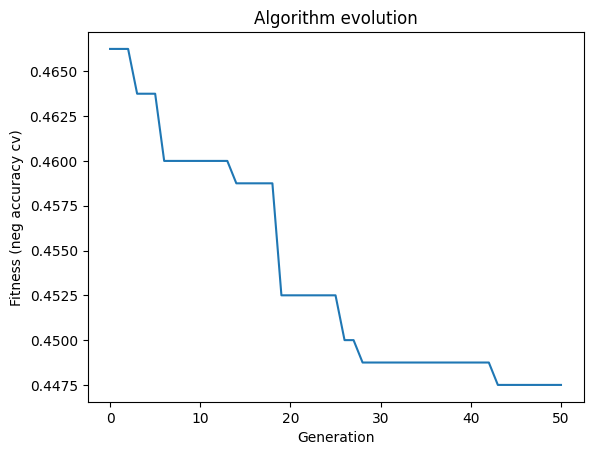

In [15]:
def VisualizaEvolucion(best_outputs):
    fig, ax = plt.subplots()
    ax.set_title("Algorithm evolution")
    plt.plot(best_outputs)
    plt.xlabel("Generation")
    plt.ylabel("Fitness (neg accuracy cv)")
    plt.show()
    
VisualizaEvolucion(best_outputs)

### Construir un modelo con los parámetros ajustados y evaluarlo en cross validation

In [16]:
beta_1,beta_2,hidden_layer_size,activation,learning_rate = dec(best_solution.xr,best_solution.xe)        
clasificadorAjustado = MLPClassifier(random_state=1, hidden_layer_sizes=(hidden_layer_size,),activation=activation,learning_rate=learning_rate,beta_1=beta_1,beta_2=beta_2)

scoresAjustado = cross_val_score(estimator=clasificadorAjustado, X=X_train, y=y_train, scoring='accuracy', cv=cv, n_jobs=-1)
accAjustado = np.mean(scoresAjustado)
print("Clasificador con los parámetros ajustados")
print("ACC cv (train) = ",accAjustado)

Clasificador con los parámetros ajustados
ACC cv (train) =  0.5387500000000001


In [17]:
# Entrenar con todo el conjunto de entrenamiento
clasificadorAjustado.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
acc_test = clasificadorAjustado.score(X_test, y_test)
print("ACC en test = ", acc_test)

ACC en test =  0.595


### Construir un modelo con los parámetros por defecto y evaluarlo en cross validation

In [18]:
clasificadorDefecto = MLPClassifier(random_state=1)

scoresDefecto = cross_val_score(estimator=clasificadorDefecto, X=X_train, y=y_train, scoring='accuracy', cv=cv, n_jobs=-1)
accDefecto = np.mean(scoresDefecto)
print("Clasificador con los parámetros por defecto")
print("ACC cv (train) = ",accDefecto)

Clasificador con los parámetros por defecto
ACC cv (train) =  0.525


In [19]:
# Entrenar con todo el conjunto de entrenamiento
clasificadorDefecto.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
acc_test_defecto = clasificadorDefecto.score(X_test, y_test)
print("ACC en test (por defecto) = ", acc_test_defecto)

ACC en test (por defecto) =  0.55
